# Разработка моделей прогноза оттока сотрдников и уровня удовлетворения работой для HR-отдела компании «Работа с заботой»

__Описание проекта:__

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. Удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

__Цель исследования:__

Наша цель:

- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

__Ход исследования__

Исследование включает в себя следующие этапы:

- Подготовка данных на представленных датасетах 
- Исследовательский анализ данных
- Корреляционный анализ признаков в датасете
- Создание лучшей модели путем подбора гиперпараметров и создания пайплайна
    

__Загрузка библиотек__

In [1]:
!pip install phik
!pip install numba==0.59.1
!pip install numpy==1.26.4
!pip install scipy==1.13.1
!pip install scikit-learn==1.5.0
!pip install seaborn==0.13.2
!pip install matplotlib==3.9.0

     |████████████████████████████████| 686 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 43.8 MB 204 kB/s eta 0:00:01
     |████████████████████████████████| 18.2 MB 89.4 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.0
    Uninstalling llvmlite-0.39.0:
      Successfully uninstalled llvmlite-0.39.0
  Attempting uninstall: numba
    Found existing installation: numba 0.56.0
    Uninstalling numba-0.56.0:
      Successfully uninstalled numba-0.56.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.26.4 which is incomp

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn import model_selection, metrics
from sklearn.ensemble import RandomForestClassifier
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    PolynomialFeatures
)

## Загрузка данных

In [2]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
df_list = [train_job_satisfaction_rate,test_features,test_target_job_satisfaction_rate]

In [4]:
train_job_satisfaction_rate.name = 'train_job_satisfaction_rate'
test_features.name = 'test_features'
test_target_job_satisfaction_rate.name = 'test_target_job_satisfaction_rate'

__Функции, которые будут использоваться в проекте__

In [5]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))

In [6]:
def num_func(df):
    numeric_cols = df.select_dtypes(include='number').columns

    num_plots = len(numeric_cols)
    plt.figure(figsize=(10, 5 * num_plots))
    
    for i, col in enumerate(numeric_cols):
        plt.subplot(num_plots, 2, 2*i + 1)
        df[col].hist(bins=15)
        plt.title(f'Гистограмма для {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.subplot(num_plots, 2, 2*i + 2)
        df.boxplot(column=col)
        plt.title(f'Диаграмма размаха {col}')
        
    plt.tight_layout()
    plt.show()

In [7]:
def cat_func(df):
    
    cat_cols = df.select_dtypes(exclude='number').columns
    
    colors = sns.color_palette('deep')
    for i in cat_cols:
        plt.title(f'Диаграмма категории {i}')
        df[i].value_counts().plot(kind='pie', 
                             legend=True, 
                             autopct='%.2f%%', 
                             textprops={'color':'white', 'size':15}, 
                             figsize=(8, 6))    
        plt.legend(bbox_to_anchor=(1, 1), prop={'size': 15})
        plt.ylabel(None)
        plt.show()
        
        

    print("===========")

In [8]:
def data_exploration_func(df):
    print('=========================')
    print('Датасет', df.name)
    display(df.head(10))
    df.info()
    display(df.describe(include='all')) 

__Константа__

In [9]:
RANDOM_STATE=42

In [10]:
for data in df_list:
    data_exploration_func(data)

Датасет train_job_satisfaction_rate


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,3994,3996,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000.000000
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,NaN
freq,NaN,1512,1894,2066,NaN,3880,3441,NaN,NaN,NaN
mean,544957.621000,NaN,NaN,NaN,3.718500,NaN,NaN,3.476500,33926.700000,0.533995
std,257883.104622,NaN,NaN,NaN,2.542513,NaN,NaN,1.008812,14900.703838,0.225327
min,100954.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,0.030000
25%,322836.750000,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,0.360000
50%,534082.500000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,0.560000
75%,771446.000000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,0.710000


Датасет test_features


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
count,2000.000000,1998,1999,2000,2000.000000,2000,2000,2000.000000,2000.000000
unique,NaN,6,3,4,NaN,2,2,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN
freq,NaN,763,974,1043,NaN,1937,1738,NaN,NaN
mean,552765.213500,NaN,NaN,NaN,3.666500,NaN,NaN,3.526500,34066.800000
std,253851.326129,NaN,NaN,NaN,2.537222,NaN,NaN,0.996892,15398.436729
min,100298.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000
25%,339052.000000,NaN,NaN,NaN,1.000000,NaN,NaN,3.000000,22800.000000
50%,550793.000000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000
75%,765763.750000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000


Датасет test_target_job_satisfaction_rate


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


Для этой задачи заказчик предоставил данные с признаками:

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

__Вывод:__ Данные загружены. Пора приступать к предобработке данных

## Предобработка данных

### Исправим имя грейда sinior на senior

In [11]:
train_job_satisfaction_rate.loc[train_job_satisfaction_rate['level'] == 'sinior', 'level'] = 'senior'
test_features.loc[test_features['level'] == 'sinior', 'level'] = 'senior'

### Проверим на пропущенные значения:

In [12]:
for data in df_list:
    display(data.name)
    display(data.isna().sum())

'train_job_satisfaction_rate'

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

'test_features'

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

'test_target_job_satisfaction_rate'

id                       0
job_satisfaction_rate    0
dtype: int64

Удалять значения не будем - заменим их в пайплайне

### Проверим на наличие дубликатов

Проверим на наличие явных дубликатов

In [13]:
for i in df_list:
    i.duplicated().sum()
    print(f'Количество дубликатов {i.name}= {i.duplicated().sum()}')

Количество дубликатов train_job_satisfaction_rate= 0
Количество дубликатов test_features= 0
Количество дубликатов test_target_job_satisfaction_rate= 0


Явных дубликатов нет

Проверим на наличие неявных дубликатов

In [14]:
train_job_satisfaction_rate['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [15]:
train_job_satisfaction_rate.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

In [16]:
for i in df_list:
    for k in i.select_dtypes(exclude='number').columns:
        print(f' Наименование значений таблицы:{i.name} \n столбца {k}  - {i[k].unique()}')
        print('================y')

 Наименование значений таблицы:train_job_satisfaction_rate 
 столбца dept  - ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
================y
 Наименование значений таблицы:train_job_satisfaction_rate 
 столбца level  - ['junior' 'middle' 'senior' nan]
================y
 Наименование значений таблицы:train_job_satisfaction_rate 
 столбца workload  - ['medium' 'high' 'low']
================y
 Наименование значений таблицы:train_job_satisfaction_rate 
 столбца last_year_promo  - ['no' 'yes']
================y
 Наименование значений таблицы:train_job_satisfaction_rate 
 столбца last_year_violations  - ['no' 'yes']
================y
 Наименование значений таблицы:test_features 
 столбца dept  - ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
================y
 Наименование значений таблицы:test_features 
 столбца level  - ['junior' 'middle' 'senior' nan]
================y
 Наименование значений таблицы:test_features 
 столбца workload  - ['medium' 'low' 'high' ' ']
=

Неявных дубликатов нет, но заметили значение помимо nan еще и наличие в столбцах dept и level пробелов. Заменим их на nan

In [17]:
test_features['dept'] = test_features['dept'].replace([' '], np.NaN, regex=True)
test_features['workload'] = test_features['workload'].replace([' '], np.NaN, regex=True)

## Исследовательский анализ данных

In [18]:
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id')
test_features = test_features.set_index('id')
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.set_index('id')

Объединим таблицу для исследовательского анализа данных.

In [19]:
df_job_satisfaction_rate = pd.concat([train_job_satisfaction_rate, test_features], ignore_index=False)

In [20]:
df_job_satisfaction_rate = df_job_satisfaction_rate.combine_first(test_target_job_satisfaction_rate)

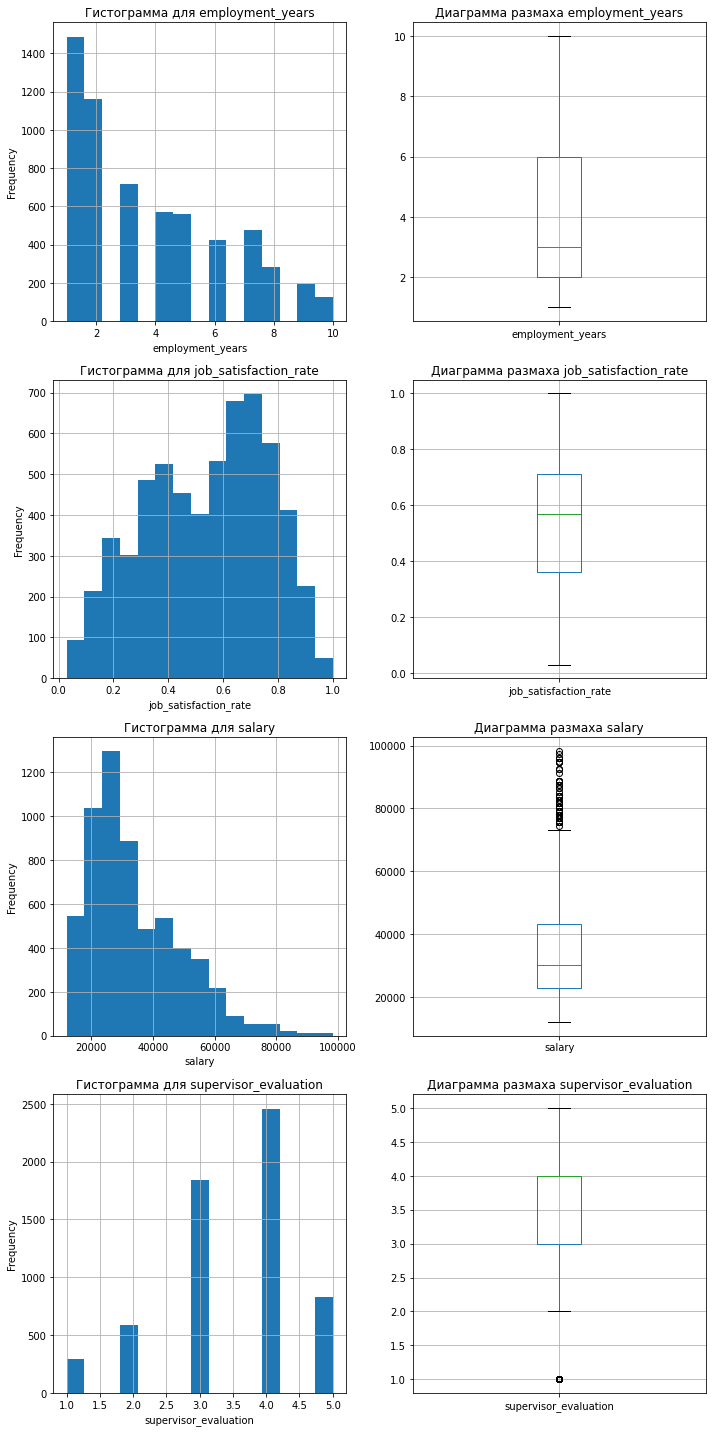

In [21]:
num_func(df_job_satisfaction_rate)

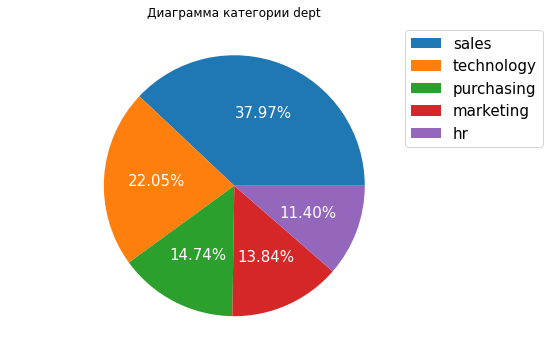

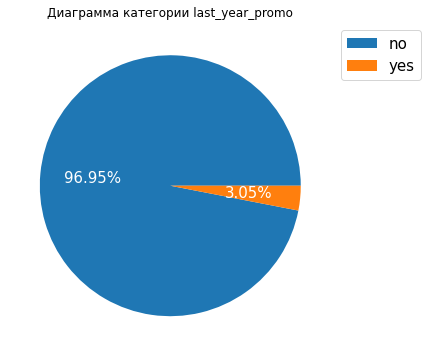

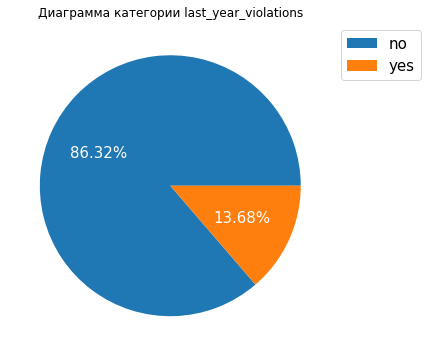

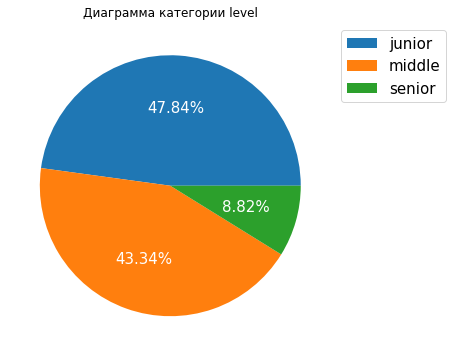

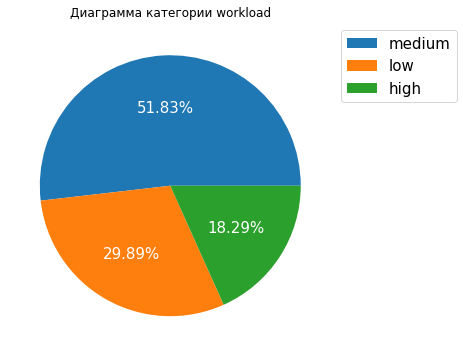

In [22]:
cat_func(df_job_satisfaction_rate)

Вывод:

- Мы собрали полностью таблицу, чтобы провести исследовательский анализ данных,
- Ненормальное распределение у salary - смещена влево (слишком много значений с зарплатой 25000), а также job_satisfaction_rate - смещена вправо. Может быть связано с большим количеством junior и middle позиций, а также количества работников из отдела продаж. С учетом что большая часть зарплаты у отдела продаж зависит от количества продаж - этим можно объяснить разницу в зарплате.
- 38% работников из отдела продаж,
- 48% составляют junior, 43 - middle, остальные - senior уровень.
- 52% работников не загружены работой (работают в нормальном темпе)
- 97% работников не повышали в уровне
- 13.68% работников нарушало трудовой договор

## Корреляционный анализ

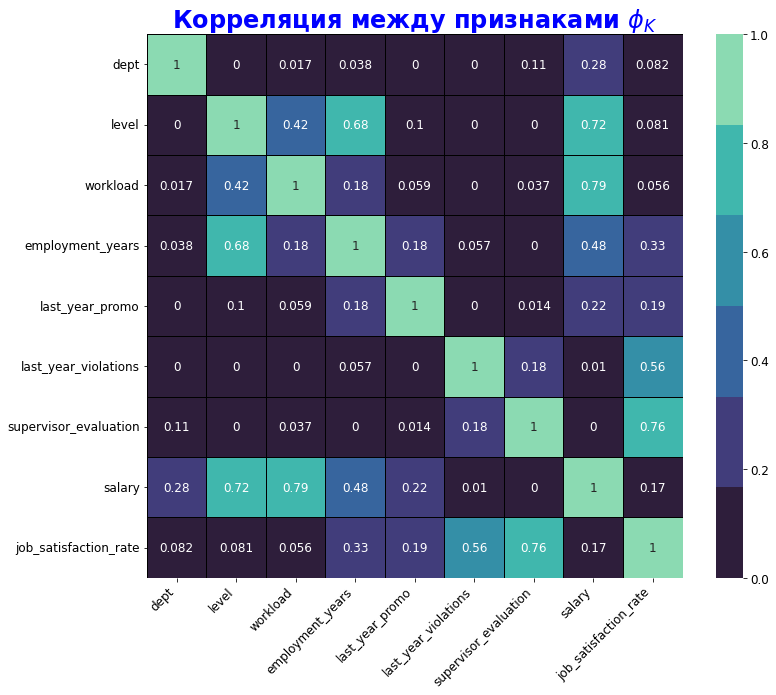

In [23]:
file = train_job_satisfaction_rate[train_job_satisfaction_rate.columns[train_job_satisfaction_rate.columns != 'id']]

all_features = list(file.columns)

correlation = file[all_features].phik_matrix(interval_cols = [ 'salary', 'job_satisfaction_rate'])

plt.figure(figsize=(12,10))
colormap = sns.color_palette("mako")
plt.rc('font', size= 12)
chart = sns.heatmap(correlation, annot=True, cmap=colormap, linewidths=1, linecolor='black')
plt.title(r'Корреляция между признаками $\phi_K$', fontsize=24, fontweight="bold", color='blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right')
plt.show()

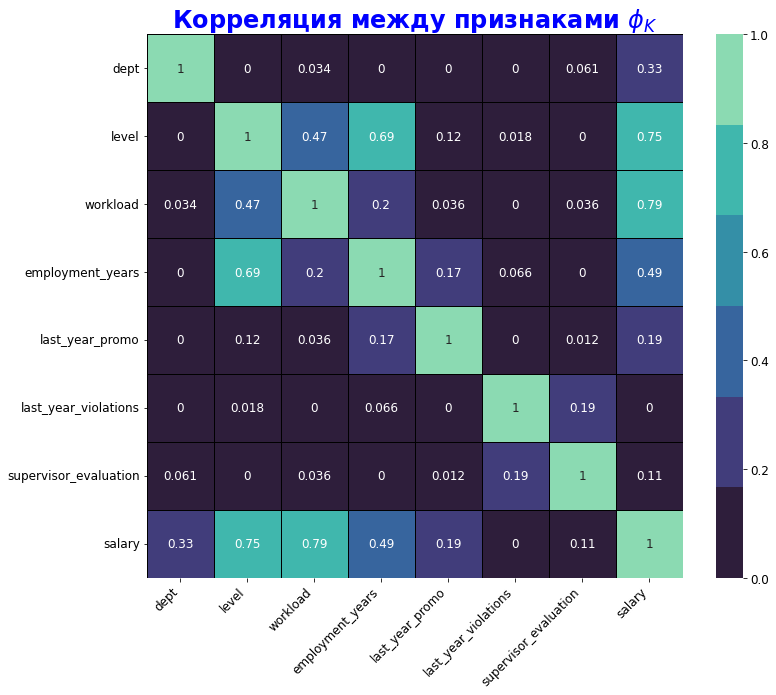

In [24]:
file = test_features[test_features.columns[test_features.columns != 'id']]

all_features = list(file.columns)

correlation = file[all_features].phik_matrix(interval_cols = [ 'salary', 'job_satisfaction_rate'])

plt.figure(figsize=(12,10))
colormap = sns.color_palette("mako")
plt.rc('font', size= 12)
chart = sns.heatmap(correlation, annot=True, cmap=colormap, linewidths=1, linecolor='black')
plt.title(r'Корреляция между признаками $\phi_K$', fontsize=24, fontweight="bold", color='blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right')
plt.show()

__Вывод:__

- Целевой признак - job_satisfaction_rate
- Корреляция с целевым признаком имеют признаки:
    - employment_years, last_year_violations, supervizor_evaluation
- Утечка даных не обнаружена.

## Подготовим пайплайн

Приступим к непосредственному построению модели.

Перечислим особенности данных:

    Три признака: Нарушения трудового договора, Повышение за последний год и Отдел — нужно кодировать с помощью OneHotEncoder.
    Два признака: Уровень должности и Уровень загруженности — нужно кодировать с помощью OrdinalEncoder.
    В признаках, закодированных этими методами, встречаются пропуски.
    Целевой признак — Удовлетворённость сотрудника работой в компании.
    Количественные признаки: Количество лет в компании, Оценка работодателя и Зарплата нужно масштабировать с помощью StandardScaler.

Наличие дубликатов в обучающей выборке не приносят дополнительной информации в модель, но создают необоснованный вес таким наблюдениям. Кроме того, увеличение объёма выборки, увеличивает расход вычислительных ресурсов и времени обучения. Узнаем их количество

In [25]:
print('Количество дубликатов:',train_job_satisfaction_rate.duplicated().sum())

Количество дубликатов: 245


245 дубликатов. Удалим их.

In [26]:
train = train_job_satisfaction_rate.drop_duplicates().reset_index(drop=True)

In [27]:
train.shape

(3755, 9)

In [28]:
X_train = train.drop(['job_satisfaction_rate'], axis=1)
y_train = train['job_satisfaction_rate']

In [29]:
test_df=test_features.merge(test_target_job_satisfaction_rate, on='id')

In [30]:
X_test = test_df.drop(['job_satisfaction_rate'], axis=1)
y_test = test_df['job_satisfaction_rate']

In [31]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=SEED)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED)

Так как целевой признак у нас непрерывный количественный, то для для обучения будем брать модели регрессии: модель линейной регрессии и дерево решений (для дерева решений используем перебор разных гиперпараметров).

In [1]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.NaN
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])
 
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(5, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

  
smape_scorer = make_scorer(score_func=smape, greater_is_better=False)

NameError: name 'Pipeline' is not defined

Мы провели подготовку данных (кодирование, масштабирование, обработка пропусков) с использованием пайплайна.
Приступаем к обучению моделей.

Т.к. параметров немного и значения не слишком большие, воспользуемся поиск перебором GridSearchCV.

In [33]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring=smape_scorer
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(5, 15),
                          'models__max_features': range(5, 15),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [34]:
best_model = grid_search.best_estimator_
print(f"Лучшая модель и её параметры:\n {best_model['models']}")
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_*(-1))

Лучшая модель и её параметры:
 DecisionTreeRegressor(max_depth=12, max_features=8, random_state=42)
Метрика лучшей модели на тренировочной выборке: 15.859813742642888


Лучшей моделью получилась модель дерево решений с максимальной глубиной - 12, максимальным числом признаков, по которым ищется лучшее разбиение в дереве - 8.

Рассчитаем метрику SMAPE на тестовой выборке.

In [35]:
y_pred = grid_search.best_estimator_.predict(X_test)
smape_test = smape(y_test, y_pred)
print ("Метрика SMAPE на тестовой выборке равна:", smape_test)

Метрика SMAPE на тестовой выборке равна: 14.212648779981658


Для поиска лучшей модели были предприняты следующие шаги:

- проведено исследование полученных даных и признаков
- в процессе поиска к данным применено 2 типа моделей классифкации
- на основе метрики SMAPE была отобрана лучшая модель ('models', DecisionTreeRegressor(max_depth=12, max_features=10, random_state=42) c использованием пайплайна
- метрика SMAPE лучшей модели на тестовой выборке составила: 14.2126

# Задача 2

## Загрузка данных

In [36]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_features_quit = pd.read_csv('/datasets/test_features.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
df_list_quit = [train_quit, test_features_quit, test_target_quit]

In [37]:
train_quit.name = 'train_quit'
test_features_quit.name = 'test_features_quit'
test_target_quit.name = 'test_target_quit'

In [38]:
for df in df_list_quit:
    data_exploration_func(df)

Датасет train_quit


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
count,4000.000000,4000,4000,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,2
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,no
freq,NaN,1438,1949,2118,NaN,3887,3455,NaN,NaN,2872
mean,552099.283750,NaN,NaN,NaN,3.701500,NaN,NaN,3.474750,33805.800000,NaN
std,260158.031387,NaN,NaN,NaN,2.541852,NaN,NaN,1.004049,15152.415163,NaN
min,100222.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,NaN
25%,327785.750000,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,NaN
50%,546673.000000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,NaN
75%,781497.750000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,NaN


Датасет test_features_quit


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
count,2000.000000,1998,1999,2000,2000.000000,2000,2000,2000.000000,2000.000000
unique,NaN,6,3,4,NaN,2,2,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN
freq,NaN,763,974,1043,NaN,1937,1738,NaN,NaN
mean,552765.213500,NaN,NaN,NaN,3.666500,NaN,NaN,3.526500,34066.800000
std,253851.326129,NaN,NaN,NaN,2.537222,NaN,NaN,0.996892,15398.436729
min,100298.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000
25%,339052.000000,NaN,NaN,NaN,1.000000,NaN,NaN,3.000000,22800.000000
50%,550793.000000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000
75%,765763.750000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000


Датасет test_target_quit


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
count,2000.000000,2000
unique,NaN,2
top,NaN,no
freq,NaN,1436
mean,552765.213500,NaN
std,253851.326129,NaN
min,100298.000000,NaN
25%,339052.000000,NaN
50%,550793.000000,NaN
75%,765763.750000,NaN


__Вывод:__ Для этой задачи используются те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

## Предобработка данных

### Исправим имя грейда sinior на senior

In [39]:
train_quit.loc[train_quit['level'] == 'sinior', 'level'] = 'senior'
test_features_quit.loc[test_features_quit['level'] == 'sinior', 'level'] = 'senior'

### Проверим на пропущенные значения:

In [40]:
for df in df_list_quit:
    display(df.name)
    display(df.isna().sum())

'train_quit'

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

'test_features_quit'

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

'test_target_quit'

id      0
quit    0
dtype: int64

Удалять значения не будем - удалим их в пайплайне

### Проверим на наличие дубликатов

Проверяем на наличие явных дубликатов

In [41]:
for i in df_list_quit:
    i.duplicated().sum()
    print(f'Количество дубликатов {i.name}= {i.duplicated().sum()}')

Количество дубликатов train_quit= 0
Количество дубликатов test_features_quit= 0
Количество дубликатов test_target_quit= 0


Явных дубликатов нет

Проверим на неявные дубликаты

In [42]:
for i in df_list_quit:
    for k in i.select_dtypes(exclude='number').columns:
        print(f' Наименование значений таблицы:{i.name} \n столбца {k}  - {i[k].unique()}')
        print('=================')

 Наименование значений таблицы:train_quit 
 столбца dept  - ['sales' 'purchasing' 'marketing' 'technology' 'hr']
 Наименование значений таблицы:train_quit 
 столбца level  - ['middle' 'junior' 'senior']
 Наименование значений таблицы:train_quit 
 столбца workload  - ['high' 'medium' 'low']
 Наименование значений таблицы:train_quit 
 столбца last_year_promo  - ['no' 'yes']
 Наименование значений таблицы:train_quit 
 столбца last_year_violations  - ['no' 'yes']
 Наименование значений таблицы:train_quit 
 столбца quit  - ['no' 'yes']
 Наименование значений таблицы:test_features_quit 
 столбца dept  - ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
 Наименование значений таблицы:test_features_quit 
 столбца level  - ['junior' 'middle' 'senior' nan]
 Наименование значений таблицы:test_features_quit 
 столбца workload  - ['medium' 'low' 'high' ' ']
 Наименование значений таблицы:test_features_quit 
 столбца last_year_promo  - ['no' 'yes']
 Наименование значений таблицы:test_feat

Заменим только пробелы. Остальные пропуски заменим в пайплайне.

In [43]:
test_features_quit['dept'] = test_features_quit['dept'].replace([' '], np.NaN, regex=True)
test_features_quit['workload'] = test_features_quit['workload'].replace([' '], np.NaN, regex=True)

## Исследовательский анализ данных

In [44]:
train_quit = train_quit.set_index('id')
test_features_quit = test_features_quit.set_index('id')
test_target_quit = test_target_quit.set_index('id')

In [45]:
df_quit = pd.concat([train_quit, test_features_quit], ignore_index=False)

In [46]:
df_quit = df_quit.combine_first(test_target_quit)

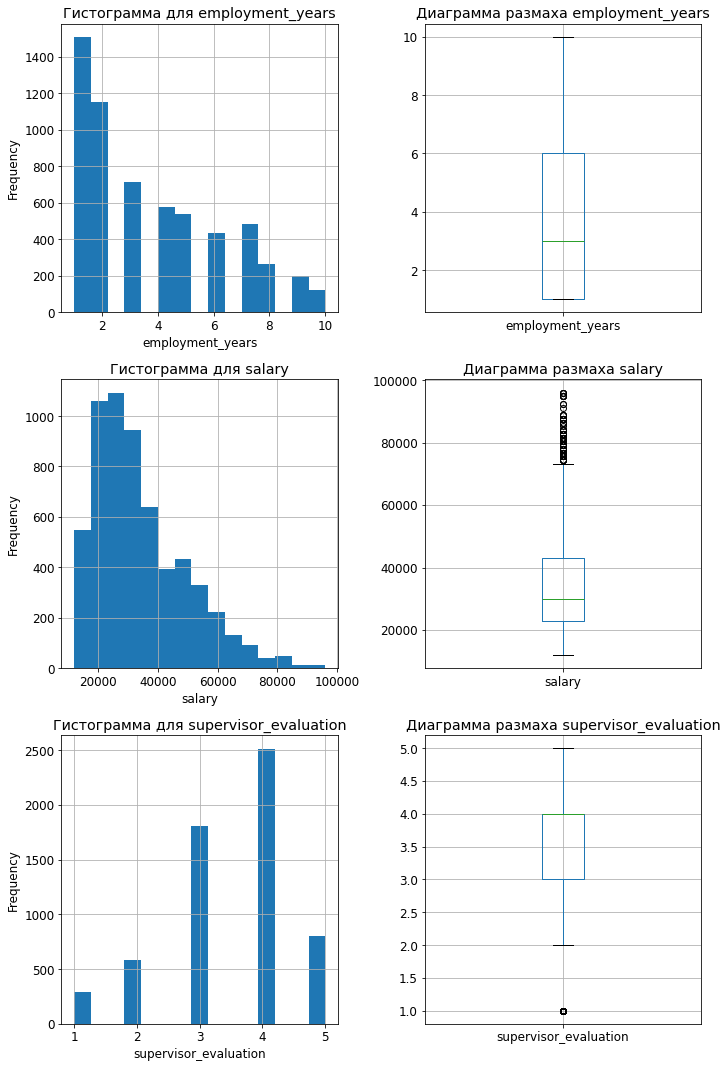

In [47]:
num_func(df_quit)

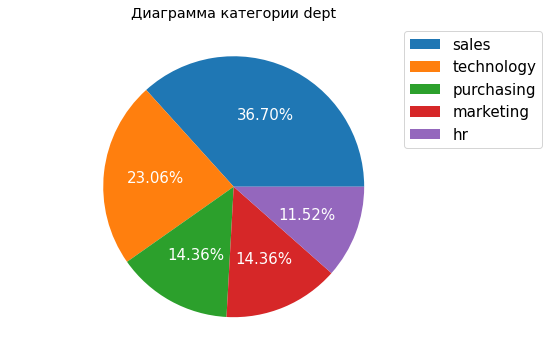

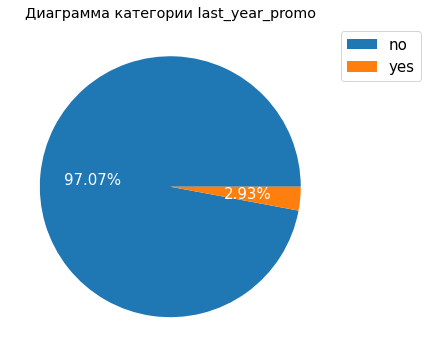

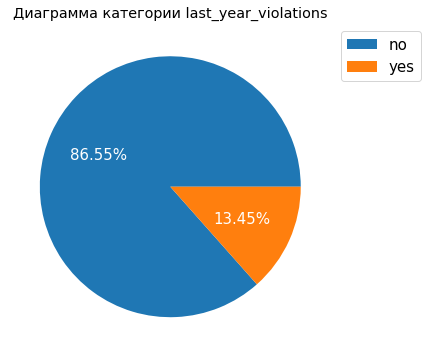

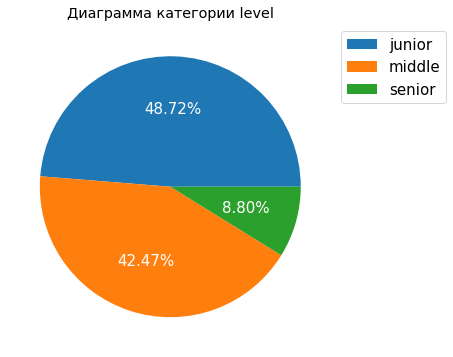

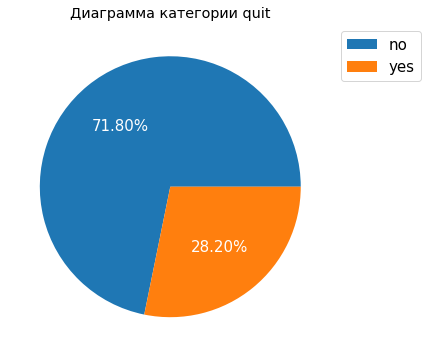

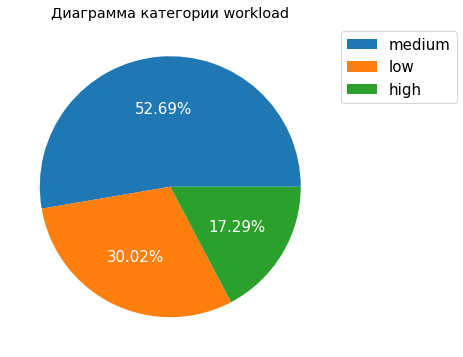

In [48]:
cat_func(df_quit)

__Вывод:__ В данных практически нет изменений, кроме добавления таблицы quit - 28.2% сотрудников уволилась

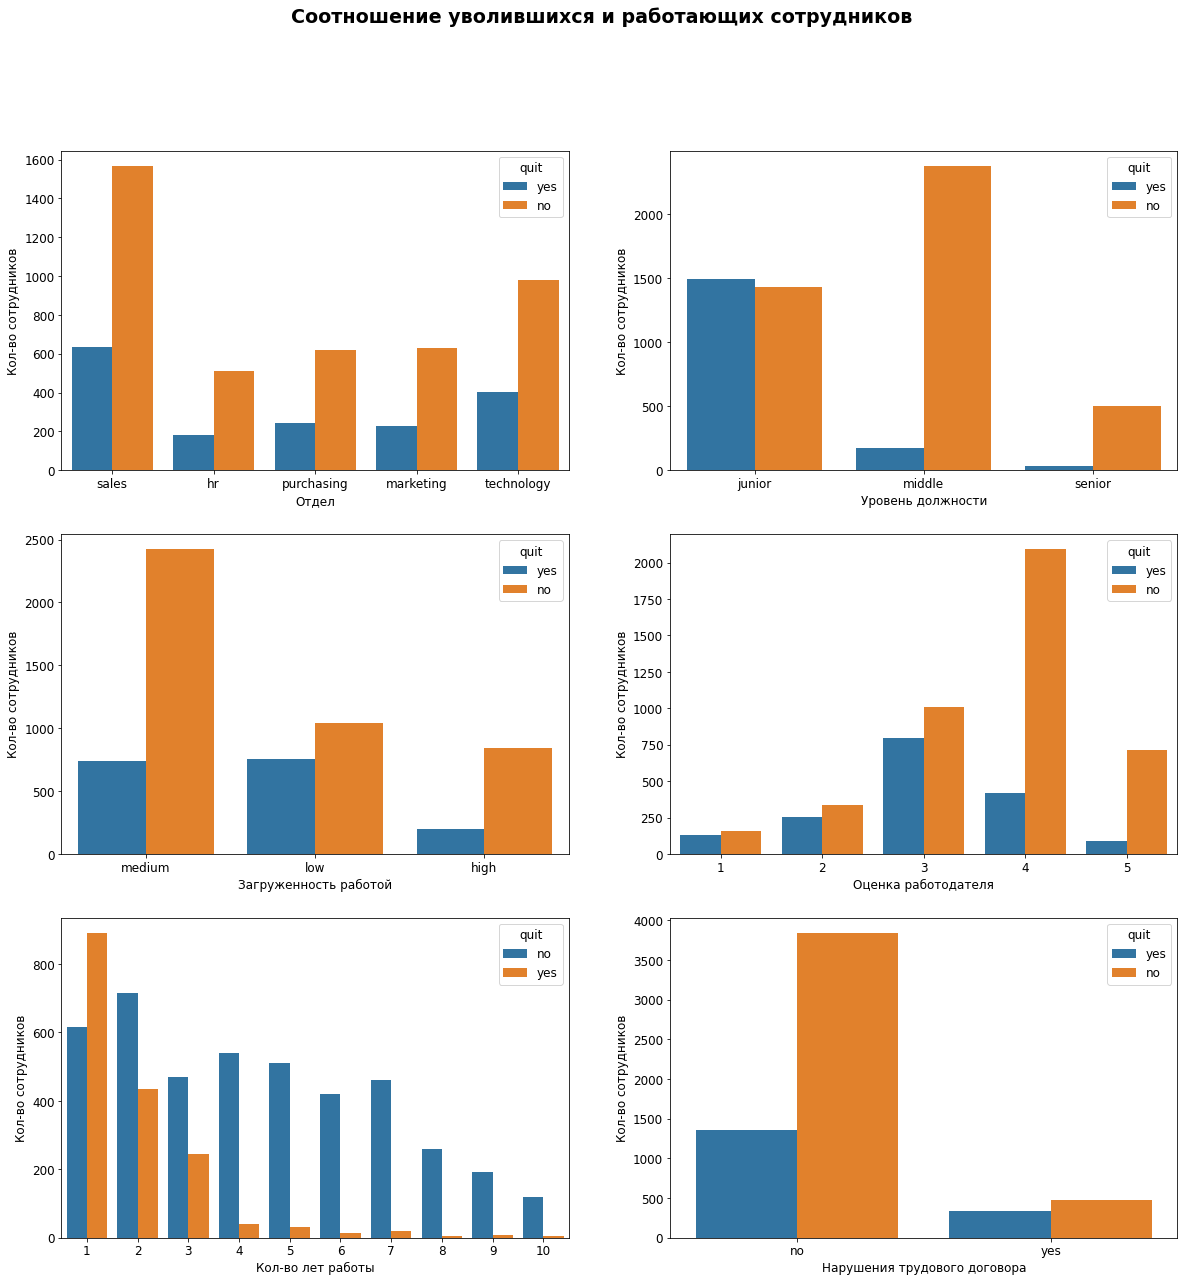

In [49]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))
plt.suptitle('Соотношение уволившихся и работающих сотрудников', fontsize=19, fontweight='bold')
sns.countplot(x ='dept', data = df_quit, hue = 'quit', ax=axes[0,0]).set(xlabel='Отдел', ylabel='Кол-во сотрудников');
sns.countplot(x ='level', data = df_quit, hue = 'quit', ax=axes[0,1]).set(xlabel='Уровень должности', ylabel='Кол-во сотрудников');
sns.countplot(x ='workload', data = df_quit, hue = 'quit', ax=axes[1,0]).set(xlabel='Загруженность работой', ylabel='Кол-во сотрудников');
sns.countplot(x ='supervisor_evaluation', data = df_quit, hue = 'quit', ax=axes[1,1]).set(xlabel='Оценка работодателя', ylabel='Кол-во сотрудников');
sns.countplot(x ='employment_years', data = df_quit, hue = 'quit', ax=axes[2,0]).set(xlabel='Кол-во лет работы', ylabel='Кол-во сотрудников');
sns.countplot(x ='last_year_violations', data = df_quit, hue = 'quit', ax=axes[2,1]).set(xlabel='Нарушения трудового договора', ylabel='Кол-во сотрудников');

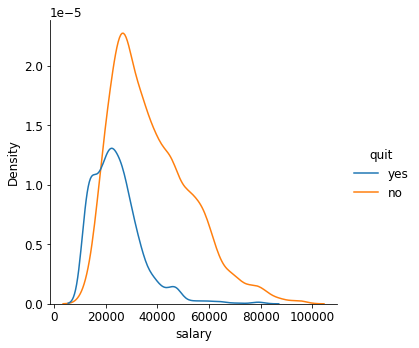

In [50]:
sns.displot(data=df_quit, x=df_quit['salary'],hue='quit', kind='kde')
plt.show()

__Вывод:__ 
- несильно но влияет отдел - увольняются чаще сотрудники из отдела продаж,
- больше всего увольняются сотрудники с уровнем должности junior,
- с уровнем загруженности работой low, 
- имеющие среднюю оценку руководителя,
- недавно работающие в компании.
- Также влияет уровень зарплаты - 20000 у тех, кто ушел, около 30000 те, кто остались

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение.

In [54]:
data_quit_employ=test_target_job_satisfaction_rate.merge(test_target_quit, on='id')

In [57]:
data_quit_employ

,job_satisfaction_rate,quit
id,,
130604,0.74,no
825977,0.75,no
418490,0.60,yes
555320,0.72,no
826430,0.08,yes
...,...,...
405257,0.28,no
370925,0.21,yes
857722,0.39,no


In [55]:
interval_cols = ['job_satisfaction_rate']
phik_overview = phik_matrix(data_quit_employ,interval_cols=interval_cols)

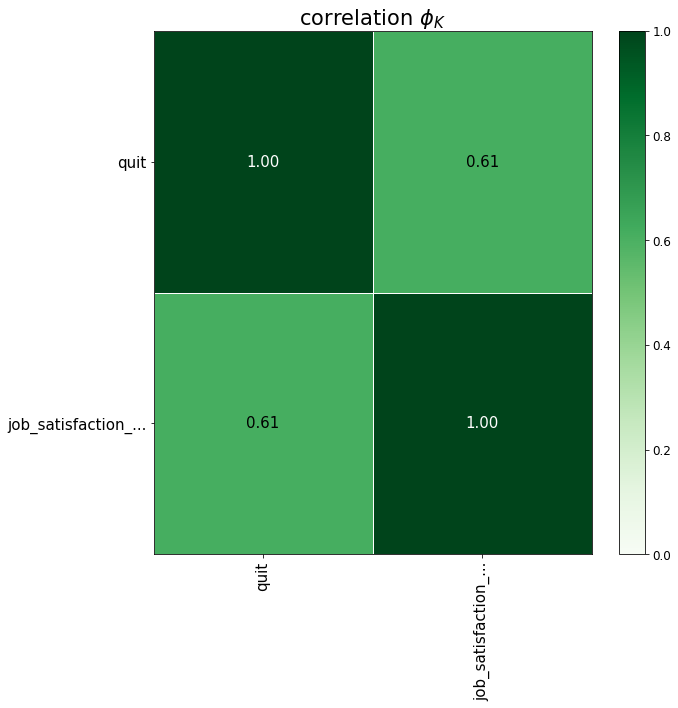

In [58]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 10)
)

__Вывод:__ удовлетворенность сотрудника работой связано с его уволнением

## Корреляционный анализ

Посмотрим, мультиколлениальны ли новый целевой признак со старым? 

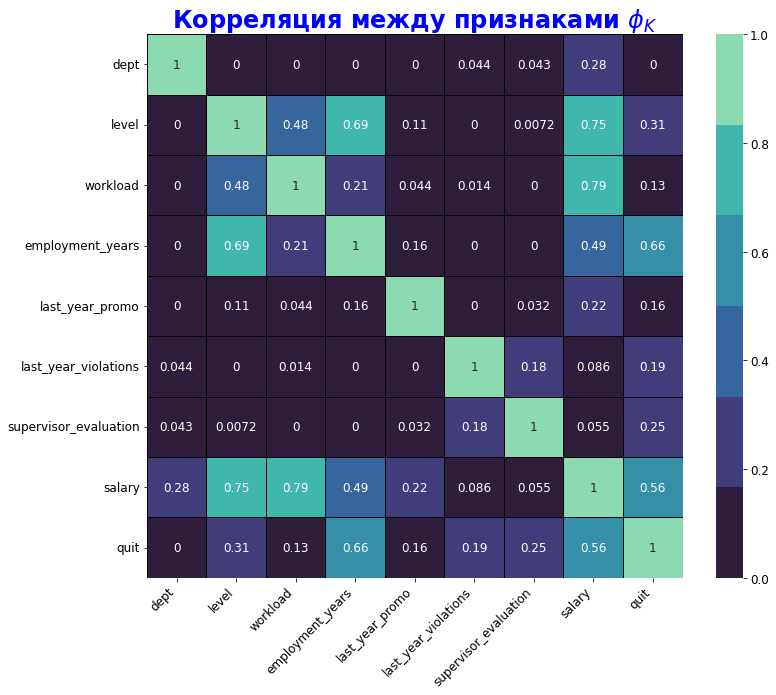

In [59]:
file = train_quit[train_quit.columns[train_quit.columns != 'id']]

all_features = list(file.columns)

correlation = file[all_features].phik_matrix(interval_cols = [ 'salary', 'job_satisfaction_rate'])

plt.figure(figsize=(12,10))
colormap = sns.color_palette("mako")
plt.rc('font', size= 12)
chart = sns.heatmap(correlation, annot=True, cmap=colormap, linewidths=1, linecolor='black')
plt.title(r'Корреляция между признаками $\phi_K$', fontsize=24, fontweight="bold", color='blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right')
plt.show()

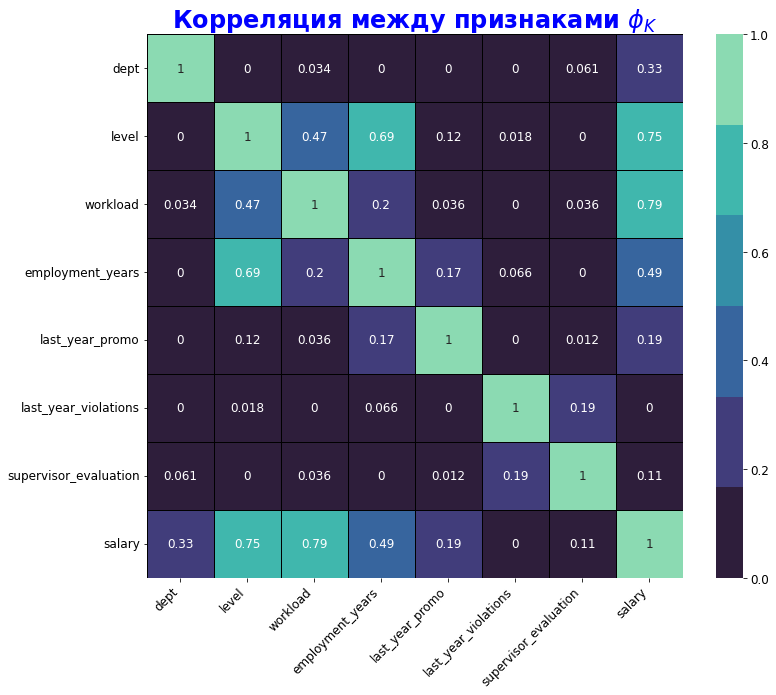

In [60]:
file = test_features[test_features.columns[test_features.columns != 'id']]

all_features = list(file.columns)

correlation = file[all_features].phik_matrix(interval_cols = [ 'salary', 'job_satisfaction_rate'])

plt.figure(figsize=(12,10))
colormap = sns.color_palette("mako")
plt.rc('font', size= 12)
chart = sns.heatmap(correlation, annot=True, cmap=colormap, linewidths=1, linecolor='black')
plt.title(r'Корреляция между признаками $\phi_K$', fontsize=24, fontweight="bold", color='blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right')
plt.show()

__Вывод:__ Мультиколлениальности между целевыми признаками не наблюдается. Утечки данных нет.

## Добавление признака

Добавим признак удовлетворенности работой в наши выборки: тестовую и тренировочную. Для этого воспользуемся нашей лучшей моделью из первой задачи. Получим предсказания удовлетворенности и добавим в виде столбца в тестовую и тренировочную выборки.

In [61]:
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit.drop(['quit'], axis=1))
train_quit.sort_values(by = 'id', ascending = True)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes,0.336000
100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.316667
100469,marketing,junior,medium,1,no,no,4,28800,no,0.664000
100601,technology,middle,high,4,no,no,4,68400,no,0.677059
100858,sales,junior,medium,2,no,no,4,25200,yes,0.842424
...,...,...,...,...,...,...,...,...,...,...
998517,purchasing,middle,low,5,no,no,3,19200,no,0.260000
999003,hr,middle,low,3,no,no,2,24000,yes,0.390000
999158,purchasing,junior,medium,1,no,yes,1,21600,yes,0.060000


In [62]:
test_features_quit['job_satisfaction_rate'] = best_model.predict(test_features_quit)
test_features_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.835745
686555,hr,junior,medium,1,no,no,4,30000,0.670417
467458,sales,middle,low,5,no,no,4,19200,0.654000
418655,sales,middle,low,6,no,no,4,19200,0.655000
789145,hr,middle,medium,5,no,no,5,40800,0.816098


Сравним уровень удовлетворенности ушедших и оставшихся работников.

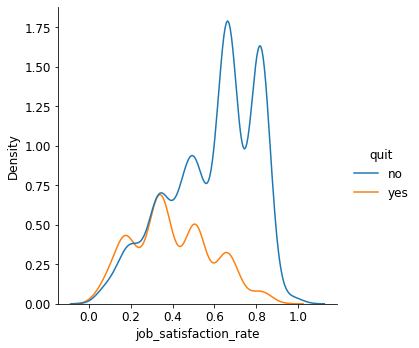

In [63]:
sns.displot(data=train_quit, x=train_quit['job_satisfaction_rate'],hue='quit', kind='kde')
plt.show()

__Вывод:__ Столбец добавлен. 
- Мы убедились, что уровень удовлетворенности работой влияет на увольнение сотрудников. Так, при уровне удовлетовренности
Можно приступать к обучению модели.

In [ ]:
print('Количество дубликатов:',train_quit.duplicated().sum())

In [ ]:
train_quit_temp = train_quit.drop_duplicates().reset_index(drop=True)

In [ ]:
train_quit_temp.shape

In [ ]:
X_train_2 = train_quit_temp.drop(['quit'], axis=1)
y_train_2 = train_quit_temp['quit']

In [ ]:
test_quit_temp=test_features_quit.merge(test_target_quit, on='id')

In [ ]:
X_test_2 = test_quit_temp.drop(['quit'], axis=1)
y_test_2 = test_quit_temp['quit']

In [ ]:
encoder = LabelEncoder()
y_train_2 = encoder.fit_transform(y_train_2)
y_test_2 = encoder.transform(y_test_2) 

In [ ]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary','job_satisfaction_rate']

In [ ]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.NaN
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
 


param_grid = [
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough'],
    },
 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough'],
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough'],
    },

    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'rbf',
            probability= True
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough'],
    }
]

Запустим обучение перебором, используя метод RandomizedSearchCV для экономии ресурсов и для ускорения работы алгоритма. Для оценки качества моделей будем использовать метрику ROC_AUC, как самую универсальную и сбалансированную метрику, которая не зависит от порога классификации.

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_2, y_train_2)

In [ ]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_['models'])
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшей моделью получилась модель kNN с количеством соседей - 59.

Рассчитаем метрику ROC-AUC на тестовой выборке.

In [ ]:
y_test_proba = randomized_search.predict_proba(X_test_2)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_2, y_test_proba)}')

__Вывод:__ Для поиска лучшей модели были предприняты следующие шаги:

- проведено исследование полученных даных и признаков
- в процессе поиска к данным применено 4 типа моделей классификации
- на основе метрики ROC-AUC была отобрана лучшая модель KNeighborsClassifier(n_neighbors=33) c использованием пайплайна
- метрика ROC-AUC лучшей модели на тестовой выборке составила: 0.915



# Итоговый вывод

__Описание задачи__

Целью проекта было разработать две модели:

- Предсказание уровня удовлетворённости сотрудника.
- Предсказание вероятности увольнения сотрудника.

__Этапы работы__

- Предсказание уровня удовлетворённости сотрудника:
    - Проведено исследование и предобработка данных: обработка пропусков, кодирование категориальных признаков, масштабирование числовых данных.
    - Выполнен исследовательский анализ данных, выявлены основные тенденции и распределения.
    - Для построения модели использованы алгоритмы регрессии: линейная регрессия и дерево решений.
    - Лучшая модель: DecisionTreeRegressor с метрикой SMAPE = 14.2126 на тестовой выборке.

- Предсказание вероятности увольнения сотрудника:
    - Проведено исследование и предобработка новых данных: проверка на пропуски и дубли.
    - Выполнен исследовательский анализ данных, составлен профиль типичного увольняющегося сотрудника.
    - Добавлен новый признак удовлетворённости работой.
    - Для построения модели использованы алгоритмы классификации: логистическая регрессия, метод опорных векторов, KNN, дерево решений.
    - Лучшая модель: KNeighborsClassifier с метрикой ROC-AUC = 0.9115.

__Выводы и предложения для бизнеса__

- Для уменьшения оттока сотрудников:
    - Обратить внимание на удовлетворённость сотрудников, так как она имеет сильную корреляцию с увольнениями.
    - Ускорить карьерный рост сотрудников, особенно перевод из junior в medium.
    - Адекватно загружать сотрудников работой, пересмотреть оценку руководителя, что будет способствовать повышению их зарплаты и удовлетворённости.

Эти меры помогут удерживать ценные кадры и снизить затраты, связанные с высоким уровнем текучести сотрудников.